# ML Topic Modeling, Feature Engineering, Dimension Reduction Visualizations

Feature engineering is the process of using domain knowledge of your data to create features that can be leveraged by machine learning.  That is not a hard definition, because sometimes it is used in a context where features are transformed for machine learning, but the inclusion of domain knowledge is not implied.  

It is unfortunately common that for large datasets engineered features are not easy to create.  When there are many features generally only a small number play an important roll when it comes to prediction.  Furthermore,  domain insight is even more difficult to fold into the model when there are hundreds or thousands of features to keep in mind.  However, there is a middle ground---much of the worlds knowledge is locked up in language.  In this case study we will use topic modeling to gather insight from text.  Ideally, the result of these types of experiments would be shared with domain experts to further engineer features that are relevant when it comes to your business opportunity.

This notebook was run with Python 3.10.11. 

In [3]:
import os
import re
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyLDAvis.gensim_models as gensimvis
from sklearn.utils import shuffle
from sklearn.datasets import load_files
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from string import punctuation, printable
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS


In [4]:
%pip install pyldavis
%pip install --upgrade numpy pandas scikit-learn gensim

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: C:\Users\willl\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


  Using cached numpy-2.2.1-cp310-cp310-win_amd64.whl (12.9 MB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: C:\Users\willl\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Need to reatart the kernel if running into errors. 

In [5]:
try:
    import pyLDAvis
    import pyLDAvis.lda_model
    import pyLDAvis.gensim_models
except:
    raise Exception("'pip install pyldavis' before running this notebook")

pyLDAvis.enable_notebook()    
plt.style.use('seaborn-v0_8')
%matplotlib inline

Make sure to save the data files in local path or modify the DATA_DIR path. 

In [6]:
DATA_DIR = os.getcwd()

## Synopsis

   >Goal:  AAVAIL has recently enabled comments on the core streaming service.  This will be an incredibly important source of data going forward.  It will be used inform customer retention, product quality, product market fit and more.  Comments are going live next week so the plan is to build a topic modeling pipeline that will consume the comments and create visualizations that can be used to communicate with domain experts.
  
## Outline

1. EDA - summary tables, use tSNE to visualize the data
2. Create a transfomation pipelines for NMF and LDA
3. Use ldaviz and wordclouds to get insight into the clusters

## Data

Comment feature is not enabled yet but I want to start building a Pipeline using a proxy dataset. In this notebook I will work with a dataset publicly available dataset of movie reviews.

Using a Cornel Dataset as a proxy for the pipeline and workflow build: http://www.cs.cornell.edu/people/pabo/movie-review-data/

In [30]:
# URL = 'https://www.cs.cornell.edu/people/pabo/movie-review-data/review_polarity.tar.gz'

# This download was modified and flattened manually so it may need an adjustment if run locally.

In [7]:
movie_reviews = load_files(os.path.join(DATA_DIR, "movie_reviews"), shuffle=True)
X = movie_reviews.data
y = movie_reviews.target
target_names = movie_reviews.target_names
print(X[4])

b"kolya is one of the richest films i've seen in some time . \nzdenek sverak plays a confirmed old bachelor ( who's likely to remain so ) , who finds his life as a czech cellist increasingly impacted by the five-year old boy that he's taking care of . \nthough it ends rather abruptly-- and i'm whining , 'cause i wanted to spend more time with these characters-- the acting , writing , and production values are as high as , if not higher than , comparable american dramas . \nthis father-and-son delight-- sverak also wrote the script , while his son , jan , directed-- won a golden globe for best foreign language film and , a couple days after i saw it , walked away an oscar . \nin czech and russian , with english subtitles . \n"


### Part 1

The main focus of this exercise is to enable visualization of topics, but these topics can be used as additional features for prediction tasks.  

This exercise will have demonstration of: natural language processing(NLP), sklearn, pipelines and topic modeling tools. 

There are many ways to process tokens (words, dates, emojis etc).  NLTK is used to pre-process text data before the tokens are vectorized.  Generally, the tokens are modified via stemming or lemmatization.  The next code block provides a lemmatization function that makes use of the library [spacy](https://spacy.io/).  To run this notebook spacy will need to be install it and download. Stopwords are words that are very common or otherwise irrelevant I use a default list here although the general rule is for these to be project specific. 

    %pip install spacy
    %python -m spacy download en

Could also use NLTK then use a simple lemmatizer like the WordLemmatizer.

In [8]:
%pip install spacy

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: C:\Users\willl\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [9]:
!python -m spacy download en
!python -m spacy download en_core_web_sm

C:\Users\willl\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\python.exe: No module named spacy
C:\Users\willl\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\python.exe: No module named spacy


In [10]:
import spacy
STOPLIST = ENGLISH_STOP_WORDS
STOPLIST = set(list(STOPLIST) + ["foo", "film", "movie", "make"])

if not 'nlp' in locals():
    print("Loading English Module...")
    spacy.cli.download("en_core_web_sm")
    nlp = spacy.load('en_core_web_sm')

def lemmatize_document(doc, stop_words=None):
    """
    takes a list of strings where each string is a document
    returns a processed list of strings
    """
    
    if not stop_words:
        stop_words = set([])
  
    # ensure working with string
    doc = str(doc)
    doc = doc.replace('\\n','')
    doc = doc.replace('\\t','')

    # First remove punctuation form string
    if sys.version_info.major == 3:
        PUNCT_DICT = {ord(punc): None for punc in punctuation}
        doc = doc.translate(PUNCT_DICT)

    # remove unicode
    clean_doc = "".join([char for char in doc if char in printable])
            
    # Run the doc through spaCy
    doc = nlp(clean_doc)

    # Lemmatize and lower text
    tokens = [re.sub(r"\W+","",token.lemma_.lower()) for token in doc ]
    tokens = [t for t in tokens if len(t) > 1]
    
    return ' '.join(w for w in tokens if w not in stop_words)    

# example usage
corpus = ['"You can fool some of the people all of the time, and all of the people some of the time, but you can not fool all of the people all of the time". -- Abraham Lincoln']
processed = [lemmatize_document(doc, STOPLIST) for doc in corpus]
print(processed[0])
processed = [lemmatize_document(doc, None) for doc in corpus]
print("\n"+processed[0])

Loading English Module...
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
fool people time people time fool people time abraham lincoln

you can fool some of the people all of the time and all of the people some of the time but you can not fool all of the people all of the time abraham lincoln


In [11]:
# Preprocess all the reviews of the corpus with the lemmatize_document() function
# and store the results in a list called processed.

processed = [lemmatize_document(doc, STOPLIST) for doc in X]
print("processing done.")

processing done.


### Part 2

Using CountVectorizer from sklearn to vectorize the documents.

Ref:

* [scikit-learn CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)
* [scikit-learn working with text](https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html)

For visualization I'll set the max_features to 500.  Once the commenting data comes in I will use a grid-search to optimize the parameter.

In [12]:
max_features = 500

# Create a CountVectorizer object
tf_vectorizer = CountVectorizer(max_features=max_features, stop_words='english') #Add in params?: max_df=0.95, min_df=2,

# Fit and transform this object to the processed reviews
tf = tf_vectorizer.fit_transform(processed)
print("ready")

ready


### Part 3

Fit a LDA model to the corpus.

Ref:
* [scikit-learn's LDA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html)
* [scikit-learn's user guide for LDA](https://scikit-learn.org/stable/modules/decomposition.html#latentdirichletallocation)

In [13]:
n_topics = 10

# Create an LDA object
lda_model = LatentDirichletAllocation(n_components=n_topics, max_iter=5, learning_method='online', learning_offset=50.,random_state=0)

# Fit the model to the bag of word we created earlier
lda = lda_model.fit(tf)

## Part 4

Visualize the corpus using pyldavis.

Ref: 
https://github.com/bmabey/pyLDAvis
* [PyLDAViz documentation](https://pyldavis.readthedocs.io/en/latest)
* [PyLDAViz demos](https://pyldavis.readthedocs.io/en/latest/readme.html#video-demos)
* [PyLDAViz lda_model](https://nbviewer.org/github/bmabey/pyLDAvis/blob/master/notebooks/LDA%20model.ipynb)

In [14]:
# Visualize the corpus using pyLDAvis
pyLDAvis.enable_notebook()
vis = pyLDAvis.lda_model.prepare(lda_model, tf, tf_vectorizer, R=20)
pyLDAvis.display(vis)

## Part 5

Use different numbers of clusters until there is decent separation in the visualization.

In [15]:
# set the number of topics
n_topics = 7

# Create the LDA model
lda_model = LatentDirichletAllocation(n_components=n_topics, max_iter=5, learning_method='online', learning_offset=50.,random_state=0)

# fit and transform the LDA model to the vecotrized corpus
lda_transformed = lda_model.fit_transform(tf)

# use the pyLDAvis to visualise the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.lda_model.prepare(lda_model, tf, tf_vectorizer)
pyLDAvis.display(vis)

The visualization here can help determine a reasonable number of number of clusters and it can serve as a communication tool.  If the goal is to find topics that are associated with customer profiles then work with marketing to refine the clustering.  Can modify the parameters to modify the clustering and visualization. This is a function of feature engineering. 

## Part 6

The idea here is to use the topics from this model to inform clustering or supervised learning. Next action is to extract and represent as a matrix.  Along the same lines, to populate a report with tabular descriptions of the data then we would need to be able to extract topic representations.  Here is a starter function:

In [16]:
def get_top_words(model, feature_names, n_top_words):
    """
    Get the top words defining the different topics of the LDA model
    INPUT : the LDA model, the names of the features of the bag of word (these are the actual words in the vocabulary) 
    and the number of top words.
    RETURN : A dictionary where the keys are the topic's ID and the values are the lists of the n_top_words top words.
    
    """
    top_words = {}
    for topic_idx, topic in enumerate(model.components_):
        _top_words = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        top_words[str(topic_idx)] = _top_words
    return top_words

Print the top k words for each topic.

In [17]:
## set n_top_words
top_words = 15

## get the vectorizer's feature names
tf_feature_names = tf_vectorizer.get_feature_names_out()

## get the top words for each topic
top_words = get_top_words(lda, tf_feature_names, top_words)

## print the topics and the top words of each topic
for topic, words in top_words.items():
    print(f"Topic {topic} : {', '.join(words)}")
    

Topic 0 : family, father, mother, child, daughter, life, boy, parent, young, live, son, home, kid, american, like
Topic 1 : scream, horror, killer, murder, sequel, summer, kevin, genre, know, original, character, kill, flick, mystery, series
Topic 2 : character, story, like, scene, good, play, time, man, life, love, just, work, way, come, performance
Topic 3 : vampire, book, novel, crime, lee, version, comic, ben, plot, jack, time, play, cast, kill, story
Topic 4 : action, like, good, just, scene, bad, character, time, story, star, plot, sequence, look, work, come
Topic 5 : like, just, good, funny, comedy, time, think, really, bad, thing, big, know, laugh, people, character
Topic 6 : alien, like, bad, just, character, ship, time, earth, evil, know, good, scene, dr, say, man
Topic 7 : effect, new, good, world, city, time, like, year, special, play, human, people, use, look, character
Topic 8 : black, van, white, king, sex, death, kill, like, american, bad, man, good, way, hard, history


## Part 7

Next I'll do a PCA and tSNE dimension reduction and visualize the topics on probability > 0.5.

In [18]:
import matplotlib
matplotlib.use('Agg')  # Use the Agg backend
import matplotlib.pyplot as plt
%matplotlib inline

<Figure size 800x550 with 0 Axes>

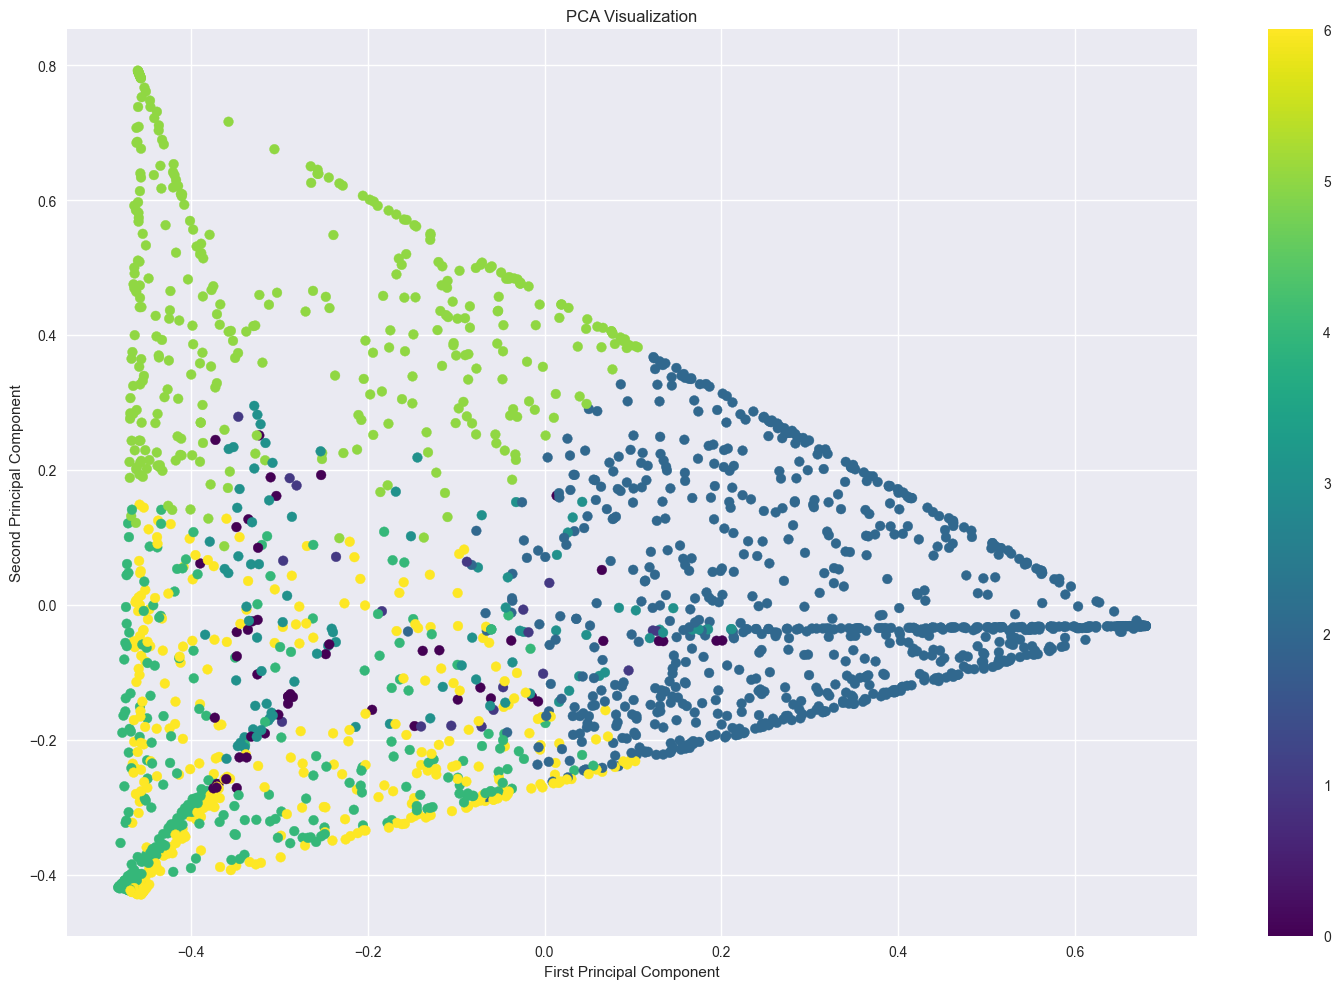

In [19]:
# do a PCA and tSNE dimension reduction and visualize the topics on probability > 0.5
n_top_words = 2  # Set n_top_words to a value between 0 and 7

# Create a PCA object
pca = PCA(n_components=n_top_words)

# Fit and transform the LDA model to the PCA
X_pca = pca.fit_transform(lda_transformed)

# Create a scatter plot for PCA
plt.clf()
plt.figure(figsize=(15, 10))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], 
                     c=np.argmax(lda_transformed, axis=1),
                     cmap='viridis')

plt.title("PCA Visualization")
plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")

# Add a colorbar
plt.colorbar(scatter)
plt.tight_layout()
plt.show()


C:\Users\willl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.001s...
[t-SNE] Computed neighbors for 2000 samples in 0.054s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.011597
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.952736
[t-SNE] KL divergence after 300 iterations: 1.163646


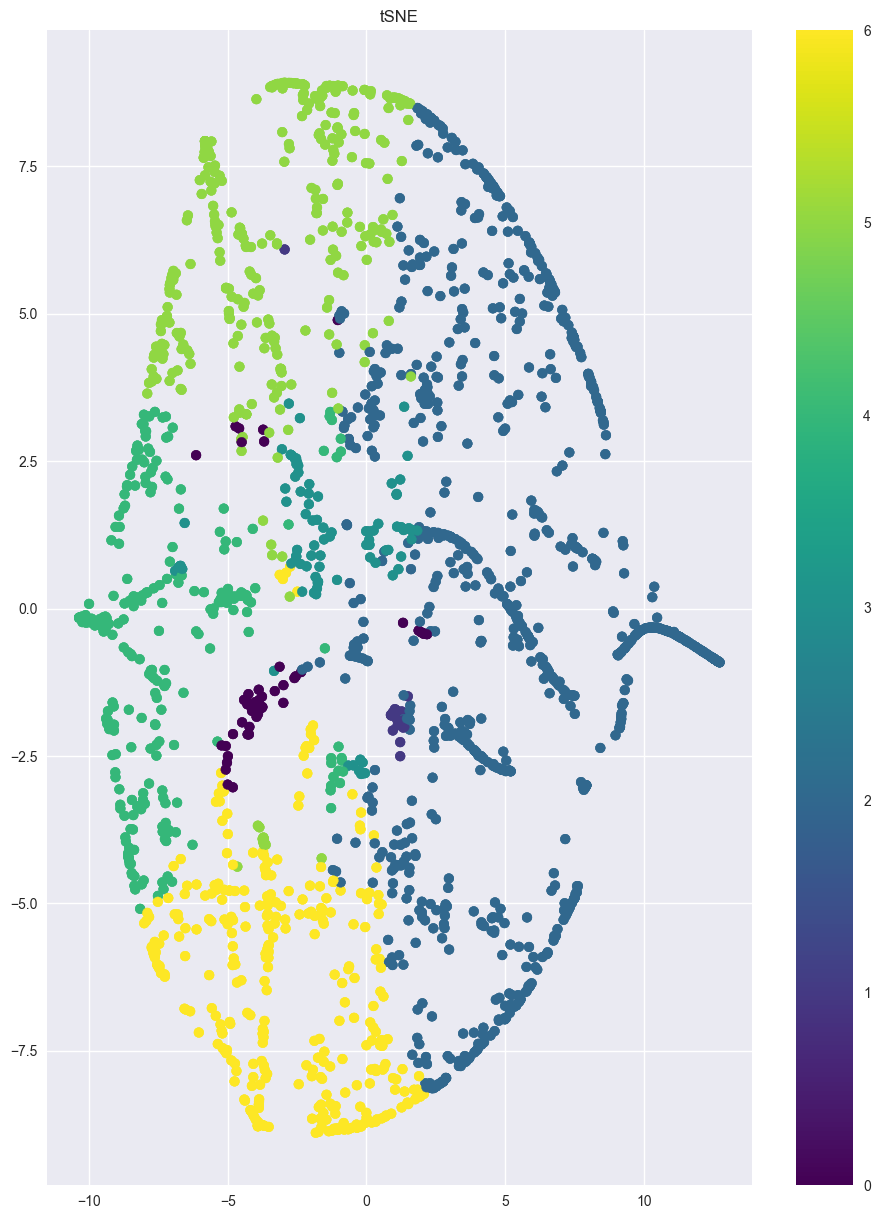

In [26]:
n_components = 2

# Create a tSNE object
tsne = TSNE(n_components=n_components, verbose=1, perplexity=50, n_iter=300)

# Fit and transform the LDA model to the tSNE
X_tsne = tsne.fit_transform(lda_transformed)

# Create a scatter plot for the tSNE
plt.figure(figsize=(25, 15))
plt.subplot(121)
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=np.argmax(lda_transformed, axis=1), cmap='viridis')
plt.colorbar(scatter)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=np.argmax(lda_transformed, axis=1), cmap='viridis')
plt.title("tSNE")
plt.show()

tSNE/PCA Plot Try #2

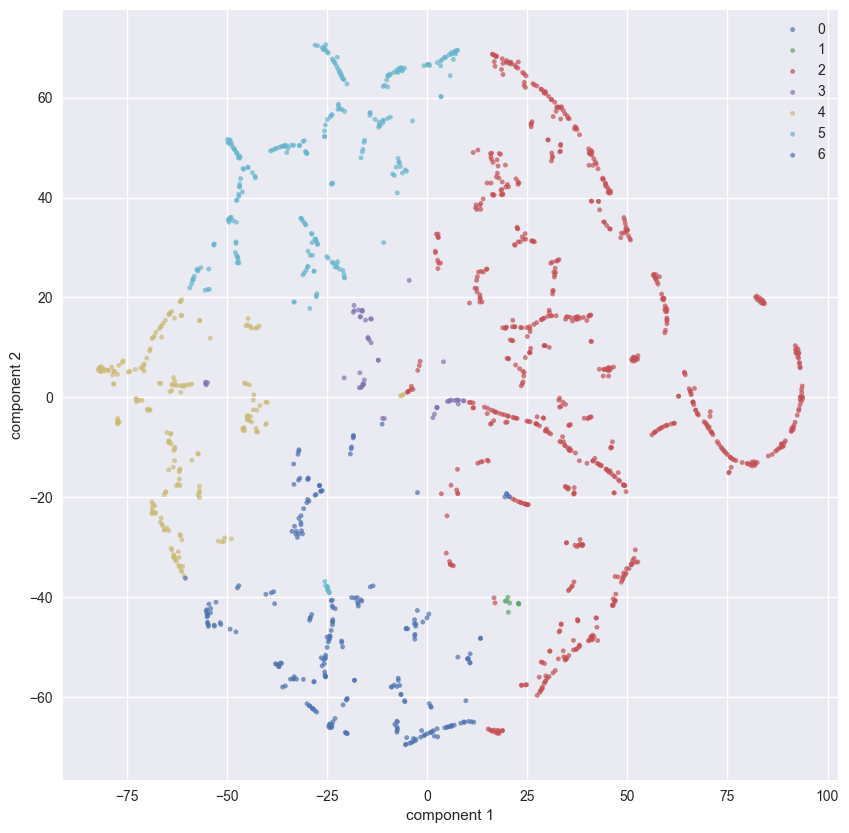

In [29]:
def make_plot(lda_mat):
    
    fig = plt.figure(figsize=(10,10), facecolor='white')
    ax = fig.add_subplot(111)
    
    tsne = TSNE(n_components=2, perplexity=10, init='pca')
    projected = tsne.fit_transform(lda_mat)
    
#     pca = PCA(n_components=2)
#     projected = pca.fit_transform(lda_mat)
    
    for class_num in np.arange(n_topics):
        topic_inds = np.where(lda_mat[:, class_num] > 0.5)[0]
        ax.scatter(projected[topic_inds, 0],
                   projected[topic_inds, 1], 
                   edgecolor='none', marker='.', alpha=0.7, label=str(class_num))

    ax.set_xlabel('component 1')
    ax.set_ylabel('component 2')
    ax.legend()
    
    
make_plot(lda_transformed)

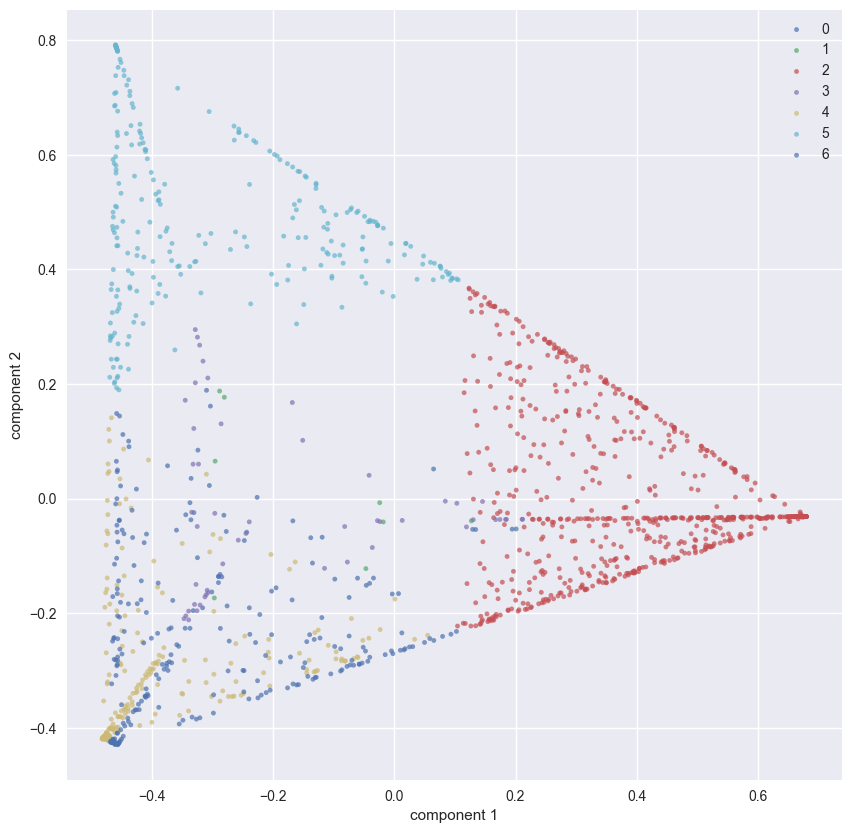

In [28]:
def make_plot(lda_mat):
    
    fig = plt.figure(figsize=(10,10), facecolor='white')
    ax = fig.add_subplot(111)
    
#    tsne = TSNE(n_components=2, perplexity=10, init='pca')
#    projected = tsne.fit_transform(lda_mat)
    
    pca = PCA(n_components=2)
    projected = pca.fit_transform(lda_mat)
    
    for class_num in np.arange(n_topics):
        topic_inds = np.where(lda_mat[:, class_num] > 0.5)[0]
        ax.scatter(projected[topic_inds, 0],
                   projected[topic_inds, 1], 
                   edgecolor='none', marker='.', alpha=0.7, label=str(class_num))

    ax.set_xlabel('component 1')
    ax.set_ylabel('component 2')
    ax.legend()
    
    
make_plot(lda_transformed)

Beautiful, we can clearly see the differentiation of topics in their reduced states and at different angles using dimension reduction techniques.  This is a completed preparation exercise for when the comments are activated and will update code internally once complete.  

I did not get to Pipelines like i expected too but the beauty of Juypter notebooks allow for the sudo representation of it here and will be completed with final version.  

---
**Author:** William Ruffu  
**Date:** Jan 2025  
**License:** All Rights Reserved | Open Source License | Freely distributable  
© 2025 William Ruffu